# Explainer notebook

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import calplot
import datetime
import folium
from folium.plugins import HeatMapWithTime
import sodapy
import pickle
from sodapy import Socrata
import time 
from scipy.spatial.distance import cdist
from geopy.distance import geodesic
from pandas.tseries.offsets import *
import warnings
warnings.filterwarnings("ignore")

## 1. Motivation

We are going to be looking into shooting incidents that have occured in New York City. We will ook into when and where the shootings occur, we will be investigating things such as - are there any boroughs that have more shootings than others? Are there some hot-spots for shooting incidents? What time of day are shootings most common? We will also be looking into the characteristics of both perpetrators and victims by answering questions such as: Which age-group commits the most shooting crimes? Are the any race-groups that are involved more in shootings? Are most victims male or female? We will also check if the age of a victim affects the fatality rate.

Furthermore, once we have analysed the shooting incidents, we will look into the effects that the shootings have on the community by looking at construction work and school attendances. Is there being invested less in areas with more shootings? How are school attendances in areas with more shootings? Does a shooting near a school affect the attendance the next day? 


All of our datasets come from the NYC open data website. We will be using [this](https://data.cityofnewyork.us/Public-Safety/NYPD-Shooting-Incident-Data-Historic-/833y-fsy8) dataset for the shooting incidents in NYC. It has 27.3K incidents, each containing the age, sex and race of both the perpetator and victim. The loaction (borough, coordinates) is also included, as well as the date and time of day. From the [construction dataset](https://data.cityofnewyork.us/Housing-Development/DOB-Job-Application-Filings/ic3t-wcy2) we will be using the latitude and longitude of each construction job filing, as well as the total estimated fee of the job. We will combine several historical attendance datasets [1](https://data.cityofnewyork.us/Education/2006-2009-Historical-Daily-Attendance-By-School/xwxx-rnki) [2](https://data.cityofnewyork.us/Education/2009-2012-Historical-Daily-Attendance-By-School/wpqj-3buw) [3](https://data.cityofnewyork.us/Education/2012-2015-Historical-Daily-Attendance-By-School/pffu-gbfi) [4](https://data.cityofnewyork.us/Education/2015-2017-Historical-Daily-Attendance-By-School/46g3-savk) such that we have a larger range of dates to analyse, as well as [this](https://data.cityofnewyork.us/Education/2010-2016-School-Safety-Report/qybk-bjjc) school safety report dataset that contains the location of the schools. The school attendance dataset contains the daily attendance, and the school safety report dataset contains the location of the schools. Finally we will look at bike data from [here](https://data.cityofnewyork.us/Transportation/Bicycle-Counters/smn3-rzf9) and [here](https://data.cityofnewyork.us/Transportation/Bicycle-Counts/uczf-rk3c).

Our goal is to make a website that tells a story about shooting incidents in New York City. It will describe

## 2. Basic stats

### 2.1 Data loading and cleaning

In order to start investigating the shooting incidents in New York City, we first need to load and clean the data, which we will do in this section.

#### Shooting dataset

We will start with the shooting incident dataset. We use Socrata to download the datafile, and we then convert it to a pandas DataFrame.

Once we have loaded our data we now need to clean it. First of all we drop some column that we will not be using. We then convert the 'occur_date' and 'occur_time' columns (both strings) to a datetime column in order to do proper analysis based on the dates later on. We also convert the latitude and longitude columns from strings to floats.

Once we have done this, we will now look into the values in some of the columns we will be using in our analysis later on, to see if we find anything that needs cleaning. Here we find that there are some 'NONE' 'U', '(null)' and 'UNKNOWN' values which we will replace with NaN's, since these are all placeholders for missing/unknown values. Furthermore, the 'perp_age_group' has some values: '1020', '940', '224' which are clearly mistakes, so we will replace these with NaN's as well.

In [2]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofnewyork.us", None)

results = client.get_all("833y-fsy8")

# Convert to pandas DataFrame
df_shooting = pd.DataFrame.from_records(results)

# Drop columns
df_shooting = df_shooting.drop(['x_coord_cd', 'y_coord_cd'], axis=1)

# Convert to datetime
df_shooting['datetime']= pd.to_datetime(df_shooting['occur_date'] + ' ' +  df_shooting['occur_time'])
df_shooting = df_shooting.drop(['occur_date', 'occur_time'], axis=1)
df_shooting['date'] = pd.to_datetime(df_shooting['datetime'], format='%Y-%m-%d').dt.date
df_shooting['date'] = pd.to_datetime(df_shooting['date'])

# Convert the latitude and longitude values to floats
df_shooting['latitude'] = df_shooting['latitude'].astype(float)
df_shooting['longitude'] = df_shooting['longitude'].astype(float)

# Look at values of specific columns
print(df_shooting['boro'].value_counts(),"\n"*2,
      df_shooting['location_desc'].value_counts().nlargest(10),"\n"*2,
      df_shooting['perp_race'].value_counts(),"\n"*2,
      df_shooting['perp_sex'].value_counts(),"\n"*2,
      df_shooting['perp_age_group'].value_counts())

# Replace placeholder/wrong values
replace_dict = {'NONE': np.nan, 'U': np.nan, '(null)': np.nan, 'UNKNOWN': np.nan, '1020': np.nan, '1022': np.nan, '940': np.nan, '224': np.nan}
df_shooting = df_shooting.replace(replace_dict)

# Show info
print(df_shooting.info())

# Show head
df_shooting.head()

BROOKLYN         10933
BRONX             7937
QUEENS            4094
MANHATTAN         3572
STATEN ISLAND      776
Name: boro, dtype: int64 

 MULTI DWELL - PUBLIC HOUS    4832
MULTI DWELL - APT BUILD      2835
(null)                        977
PVT HOUSE                     951
GROCERY/BODEGA                694
BAR/NIGHT CLUB                628
COMMERCIAL BLDG               292
RESTAURANT/DINER              204
NONE                          175
BEAUTY/NAIL SALON             112
Name: location_desc, dtype: int64 

 BLACK                             11432
WHITE HISPANIC                     2341
UNKNOWN                            1836
BLACK HISPANIC                     1314
(null)                              640
WHITE                               283
ASIAN / PACIFIC ISLANDER            154
AMERICAN INDIAN/ALASKAN NATIVE        2
Name: perp_race, dtype: int64 

 M         15439
U          1499
(null)      640
F           424
Name: perp_sex, dtype: int64 

 18-24      6222
25-44      5687

incident_key    boro precinct jurisdiction_code  statistical_murder_flag  \
0    228798151  QUEENS      105                 0                    False   
1    137471050   BRONX       40                 0                    False   
2    147998800  QUEENS      108                 0                     True   
3    146837977   BRONX       44                 0                    False   
4     58921844   BRONX       47                 0                     True   

  vic_age_group vic_sex        vic_race   latitude  longitude  ...  \
0         18-24       M           BLACK  40.662965 -73.730839  ...   
1         18-24       M           BLACK  40.810352 -73.924942  ...   
2         25-44       M           WHITE  40.742607 -73.915492  ...   
3           <18       M  WHITE HISPANIC  40.837782 -73.919457  ...   
4         45-64       M           BLACK  40.886238 -73.852910  ...   

  :@computed_region_efsh_h5xi :@computed_region_f5dn_yrer perp_age_group  \
0                       24018                          63            NaN   
1                       10932                          49            NaN   
2                       14787                          53            NaN   
3                       10930                          50            NaN   
4                       11275                          29          25-44   

  perp_sex perp_race location_desc loc_of_occur_desc loc_classfctn_desc  \
0      NaN       NaN           NaN               NaN                NaN   
1      NaN       NaN           NaN               NaN                NaN   
2      NaN       NaN           NaN               NaN                NaN   
3      NaN       NaN           NaN               NaN                NaN   
4        M     BLACK           NaN               NaN                NaN   

             datetime       date  
0 2021-05-27 21:30:00 2021-05-27  
1 2014-06-27 17:40:00 2014-06-27  
2 2015-11-21 03:56:00 2015-11-21  
3 2015-10-09 18:30:00 2015-10-09  
4 2009-02-19 22:58:00 2009-02-19  

[5 rows x 24 columns]

Now that the cleaning has been done for the shooting incidents dataset, we can see that our dataframe contains 27,312 shooting incidents, which contain information about the date, time and location of the incident, as well as the age, sex and race of both the perpetrator and victim. Furthermore, it also contains a description of the location, and whether ot not the vitim was murdered.

The only columns which contain notable missing information are 'location_desc', 'perp_age_group', 'perp_sex' and 'perp_race'. The 'location_desc' column contains information about the location of the incident, e.g. whether it's an aprtment building, a public area, etc. So the reason why some data is missing here is because it might not have been reported. The other columns are about the perpetrator. These missing values are likely due to the perpetrator not being found.

#### School attendance dataset

We will create the school attendance dataset. The first step in this process is to get all the attendance datasets and merge them together. This takes a long time to run, so we have done this already and saved the resulting csv file as `Merged_Attendance.csv`. We will then load the school safety report dataset, again using Socrata, and take only the latitude, longitude and dbn (schoolID) columns. We then merge the two datastes such that we also get the latitude and longitude on the attendance dataset.

The data cleaning for this dataset involves first dropping duplicate values as well as missing values before merging the two datasets together. Once we have merged them together, we drop rows which do not have any latitude and/or longitude information. We will create a datetime column for the date and month, create a column for % attendance, and a new column for the borough of the school. Finally, we will calculate the z-scores for attendance for each day.

In [3]:
client = Socrata("data.cityofnewyork.us", None)

'''
Takes long time to run
# Define a list of the URLs for the attendance datasets
attendance_urls = [
    "xwxx-rnki",
    "wpqj-3buw",
    "pffu-gbfi",
    "46g3-savk",
    "xc44-2jrh"
]

# Create a list comprehension to read each CSV file into a data frame and store it in a list
dfs = [pd.DataFrame.from_records(client.get_all(url)) for url in attendance_urls]

# Concatenate all the data frames in the dfs list into a single data frame
attendance_df = pd.concat(dfs)

attendance_df.to_csv('Merged_Attendance.csv')
'''

results = client.get_all("qybk-bjjc")

schools_df = pd.DataFrame.from_records(results,columns=['longitude','latitude','dbn'])
schools_df.drop_duplicates(inplace=True)
schools_df['latitude']=schools_df['latitude'].astype(float)
schools_df['longitude']=schools_df['longitude'].astype(float)

attendance_df=pd.read_csv('Merged_Attendance.csv', dtype={'school': str,'date': str},index_col=0)
attendance_df.drop_duplicates(inplace=True)

# drop duplicate rows
attendance_df.drop_duplicates(inplace=True)

num_nan = attendance_df['school'].isnull().sum()
print(f"There are {num_nan} NaN values in column 'school'.")

# drop rows with NaN values in column 'school'
attendance_df.dropna(subset=['school'],inplace=True)


school_df = pd.merge(attendance_df, schools_df, left_on='school', right_on='dbn', how='left')
del school_df['dbn']

# Print the number of rows not found
print(f"{school_df['latitude'].isnull().sum()} rows were not found in the schools dataset.")
school_df.dropna(subset=['latitude'],inplace=True)

# Create datetime columns
school_df['date'] = school_df['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y%m%d').strftime('%Y-%m-%d'))
school_df['date'] = pd.to_datetime(school_df['date'])
school_df['month'] = (school_df['date'].dt.year-2006)*12+school_df['date'].dt.month

# Borough and attendance%
school_df['borough'] = school_df['school'].apply(lambda x: x[2])
school_df['attendance'] =  (school_df['present']) / school_df['enrolled']

# group the school dataframe by date and calculate the mean and standard deviation of attendance for each date
grouped_df = school_df.groupby(['date'])['attendance'].agg(['mean', 'std']).reset_index()

# merge the grouped data back into the original school dataframe based on the date column
school_df = pd.merge(school_df, grouped_df, on=['date'])

# calculate the z-score for attendance for each date, based on the mean and standard deviation for that date
school_df['z_score'] = (school_df['attendance'] - school_df['mean']) / school_df['std']

# Prints the first columns and few rows of the dataframe
print('Number of entries:', len(school_df))
school_df.head()

There are 727707 NaN values in column 'school'.
84491 rows were not found in the schools dataset.
Number of entries: 2992352


school       date  schoolyear  enrolled  present  absent  released  \
0  01M015 2006-09-05    20062007     252.0    226.0    26.0       0.0   
1  01M019 2006-09-05    20062007     323.0    290.0    33.0       0.0   
2  01M020 2006-09-05    20062007     650.0    605.0    45.0       0.0   
3  01M034 2006-09-05    20062007     376.0    325.0    51.0       0.0   
4  01M063 2006-09-05    20062007     210.0    193.0    17.0       0.0   

   longitude   latitude  month borough  attendance      mean       std  \
0 -73.979022  40.721807      9       M    0.896825  0.862151  0.096213   
1 -73.983818  40.729636      9       M    0.897833  0.862151  0.096213   
2 -73.986648  40.721540      9       M    0.930769  0.862151  0.096213   
3 -73.975181  40.726473      9       M    0.864362  0.862151  0.096213   
4 -73.986381  40.724117      9       M    0.919048  0.862151  0.096213   

    z_score  
0  0.360397  
1  0.370868  
2  0.713197  
3  0.022981  
4  0.591367

The school attendance dataset contains almost 3 million entries, each containing the number of students present, total enrolled students, coordinates, month, borough, and z-score for a specific school on a specific date.

#### Construction dataset

We will now load and clean the construction dataset. We have loaded it using Socrata and saved it as a csv file already, since this process took a long time.

To clean it we will first convert the `total_est_fee` column, as well as the coordinate columns, from string to float values as we need to be able to use the numeric values.

In [4]:
'''
Takes long time
results = client.get_all("ic3t-wcy2")
construction_df = pd.DataFrame.from_records(results)
construction_df=construction_df[['job__','borough','gis_latitude', 'gis_longitude','total_est__fee', 'proposed_no_of_stories', 'job_type','proposed_occupancy']]
construction_df.to_csv('Construction_applications_v2.csv')
'''
# Loading csv
construction_df=pd.read_csv('Construction_applications_v2.csv')

# Prints the first columns and few rows of the dataframe
print('Columns in dataset:')
print(construction_df.columns)

# Convert fee to float
construction_df['total_est__fee']=construction_df['total_est__fee'].str.replace('$', '').astype(float)

# Convert coordinates to floats
construction_df.gis_latitude=construction_df.gis_latitude.astype(float)
construction_df.gis_longitude=construction_df.gis_longitude.astype(float)

print('Number of entries:', len(construction_df))
construction_df.head()

Columns in dataset:
Index(['Unnamed: 0', 'job__', 'borough', 'gis_latitude', 'gis_longitude',
       'total_est__fee', 'proposed_no_of_stories', 'job_type',
       'proposed_occupancy'],
      dtype='object')
Number of entries: 2698422


Unnamed: 0      job__   borough  gis_latitude  gis_longitude  \
0           0  301793156  BROOKLYN     40.685185     -73.912220   
1           1  301776077  BROOKLYN     40.717318     -73.955431   
2           2  301776291  BROOKLYN     40.638728     -74.001250   
3           3  302163557  BROOKLYN     40.687317     -73.979159   
4           4  301773631  BROOKLYN     40.659043     -73.960526   

   total_est__fee  proposed_no_of_stories job_type proposed_occupancy  
0          200.00                       3       A3                NaN  
1          150.30                       5       A2                NaN  
2          682.30                       3       A1                J-0  
3         9866.44                      12       A1                J-2  
4          603.50                       3       A1                COM

#### Bike dataset

We will now create the bike dataset, gathered from [here](https://data.cityofnewyork.us/Transportation/Bicycle-Counters/smn3-rzf9) and [here](https://data.cityofnewyork.us/Transportation/Bicycle-Counts/uczf-rk3c). The first dataset contains locational data about where bicicle counters are, and the second dataset contain information about how many bikes there are. We have already loaded both and sent them to a csv file which we will load here. We then convert the latitude and longitude to floats, remove error values, and merge the two datastes.

In [5]:
# create a client object using the Socrata library
client = Socrata("data.cityofnewyork.us", None)

'''
Takes long time to run 
results = client.get_all("uczf-rk3c")
count_df = pd.DataFrame.from_records(results)
count_df.to_csv('Bike_count.csv')
'''
count_df=pd.read_csv('Bike_count.csv',dtype={'id':str},index_col=0)

# retrieve all data from the specified dataset
results = client.get_all("smn3-rzf9")
count_location = pd.DataFrame.from_records(results)
count_location = count_location[['latitude','longitude','id']]
count_location['latitude']=count_location['latitude'].astype(float)
count_location['longitude']=count_location['longitude'].astype(float)


# Merge the two datasets on the "id" column
bike_df = pd.merge(count_df, count_location, on='id')

# Count the number of rows in the first dataset that are not in the merged dataset
non_matching_rows = bike_df[~bike_df['id'].isin(count_df['id'])].shape[0]

# Remove error values
bike_df=bike_df[bike_df['latitude']>35] # Remove error

# Print the number of non-matching rows
print(f"Number of non-matching rows: {non_matching_rows}")

# Prints the first columns and few rows of the dataframe
bike_df.head()

Number of non-matching rows: 0


countid         id                     date  counts  status   latitude  \
0  10014848  100009425  2022-06-24T00:00:00.000      15       0  40.671288   
1  10014849  100009425  2022-06-24T00:15:00.000      12       0  40.671288   
2  10014850  100009425  2022-06-24T00:30:00.000      14       0  40.671288   
3  10014851  100009425  2022-06-24T00:45:00.000       5       0  40.671288   
4  10014852  100009425  2022-06-24T01:00:00.000      10       0  40.671288   

   longitude  
0 -73.971382  
1 -73.971382  
2 -73.971382  
3 -73.971382  
4 -73.971382

### 2.2 Initial data analysis

We will now be perfomrming some initial data analysis on the shooting dataset, in order to get some insights about the dataset and patterns of the shootings in NYC.

#### Time and dates of incidents
We will start by looking at the date and time occurences of the shooting incidents. We will show a bar plot of the number of incidents in each hour of the day, as well as a calendar plot from 2006 to 2021.

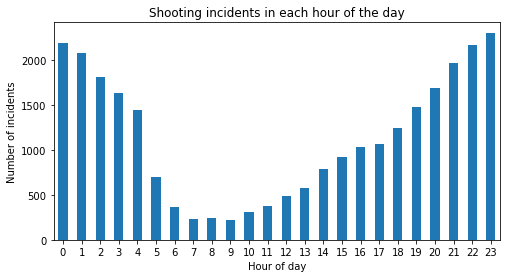

In [6]:
# Get number of incidents in each hour of the day
incidents_hour = df_shooting.datetime.dt.hour.value_counts().reindex(np.arange(24))

# Plot
plt.figure(figsize=(8,4))
incidents_hour.plot.bar(rot=0)
plt.title('Shooting incidents in each hour of the day')
plt.xlabel('Hour of day')
plt.ylabel('Number of incidents')
plt.show()

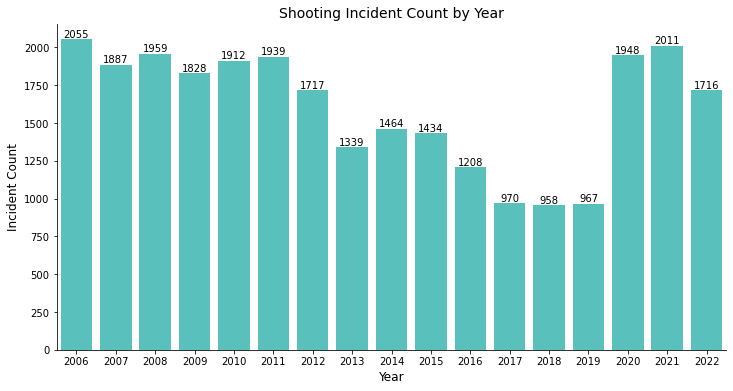

In [7]:
# Get number of incidents in each year
incidents_year = df_shooting.datetime.dt.year.value_counts().sort_index()

# Create horizontal bar plot using Seaborn with the ordered groups
plt.figure(figsize=(12, 6))
sns.barplot(y=incidents_year.values, x=incidents_year.index, color='mediumturquoise')

# Set plot title and axis labels
plt.title('Shooting Incident Count by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Incident Count', fontsize=12)

# Remove top and right spines
sns.despine()

# Add value labels to bars
for i, v in enumerate(incidents_year.values):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Show plot
plt.show()

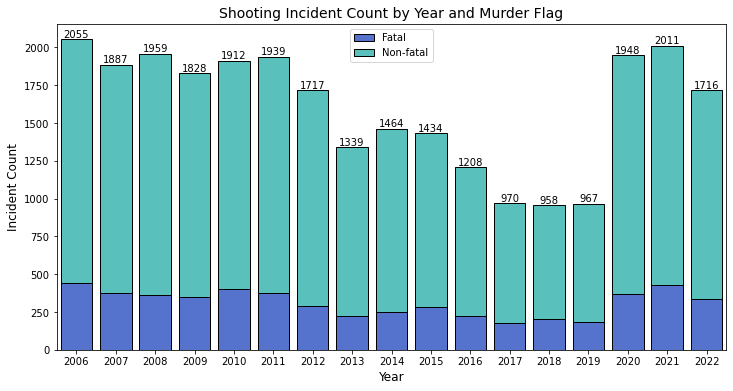

In [8]:
# Group incidents by year and murder flag
incidents_grouped = df_shooting.groupby([df_shooting.datetime.dt.year, 'statistical_murder_flag']).size().reset_index(name='count')

# Pivot the table to make it suitable for stacking
incidents_pivot = incidents_grouped.pivot(index='datetime', columns='statistical_murder_flag', values='count').fillna(0)
incidents_pivot.columns = ['No', 'Yes']

# Plot the stacked bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=incidents_pivot.index, y=incidents_pivot['Yes'], color='royalblue', label='Fatal', linewidth=1, edgecolor='black')
sns.barplot(x=incidents_pivot.index, y=incidents_pivot['No'], color='mediumturquoise', bottom=incidents_pivot['Yes'], label='Non-fatal', linewidth=1, edgecolor='black')

# Set plot title and axis labels
plt.title('Shooting Incident Count by Year and Murder Flag', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Incident Count', fontsize=12)

# Add legend
plt.legend()

# # Remove top and right spines
# sns.despine()

# Add value labels to bars
for i, v in enumerate(incidents_pivot['Yes'] + incidents_pivot['No']):
    plt.text(i, v, str(int(v)), ha='center', va='bottom')

# Show plot
plt.savefig(fname='fatal vs non-fatal.jpg')
plt.show()

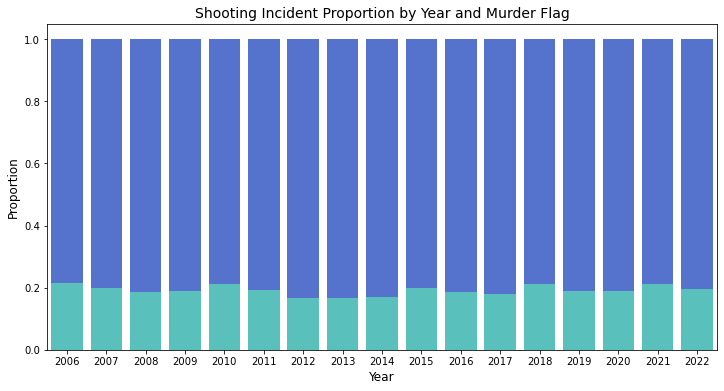

In [9]:
# Calculate the proportion of each category by year
incidents_grouped['proportion'] = incidents_grouped.groupby('datetime')['count'].apply(lambda x: x/x.sum())

# Pivot the table to create a 100% stacked bar chart
incidents_pivot = incidents_grouped.pivot(index='datetime', columns='statistical_murder_flag', values='proportion')
incidents_pivot.columns = ['No', 'Yes']  # Rename the columns

# Plot the 100% stacked bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=incidents_pivot.index, y=incidents_pivot['Yes'], color='mediumturquoise')
sns.barplot(x=incidents_pivot.index, y=incidents_pivot['No'], color='royalblue', bottom=incidents_pivot['Yes'])

# Set plot title and axis labels
plt.title('Shooting Incident Proportion by Year and Murder Flag', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Proportion', fontsize=12)

# Show plot
plt.savefig(fname='fatality distribution.jpg')
plt.show()

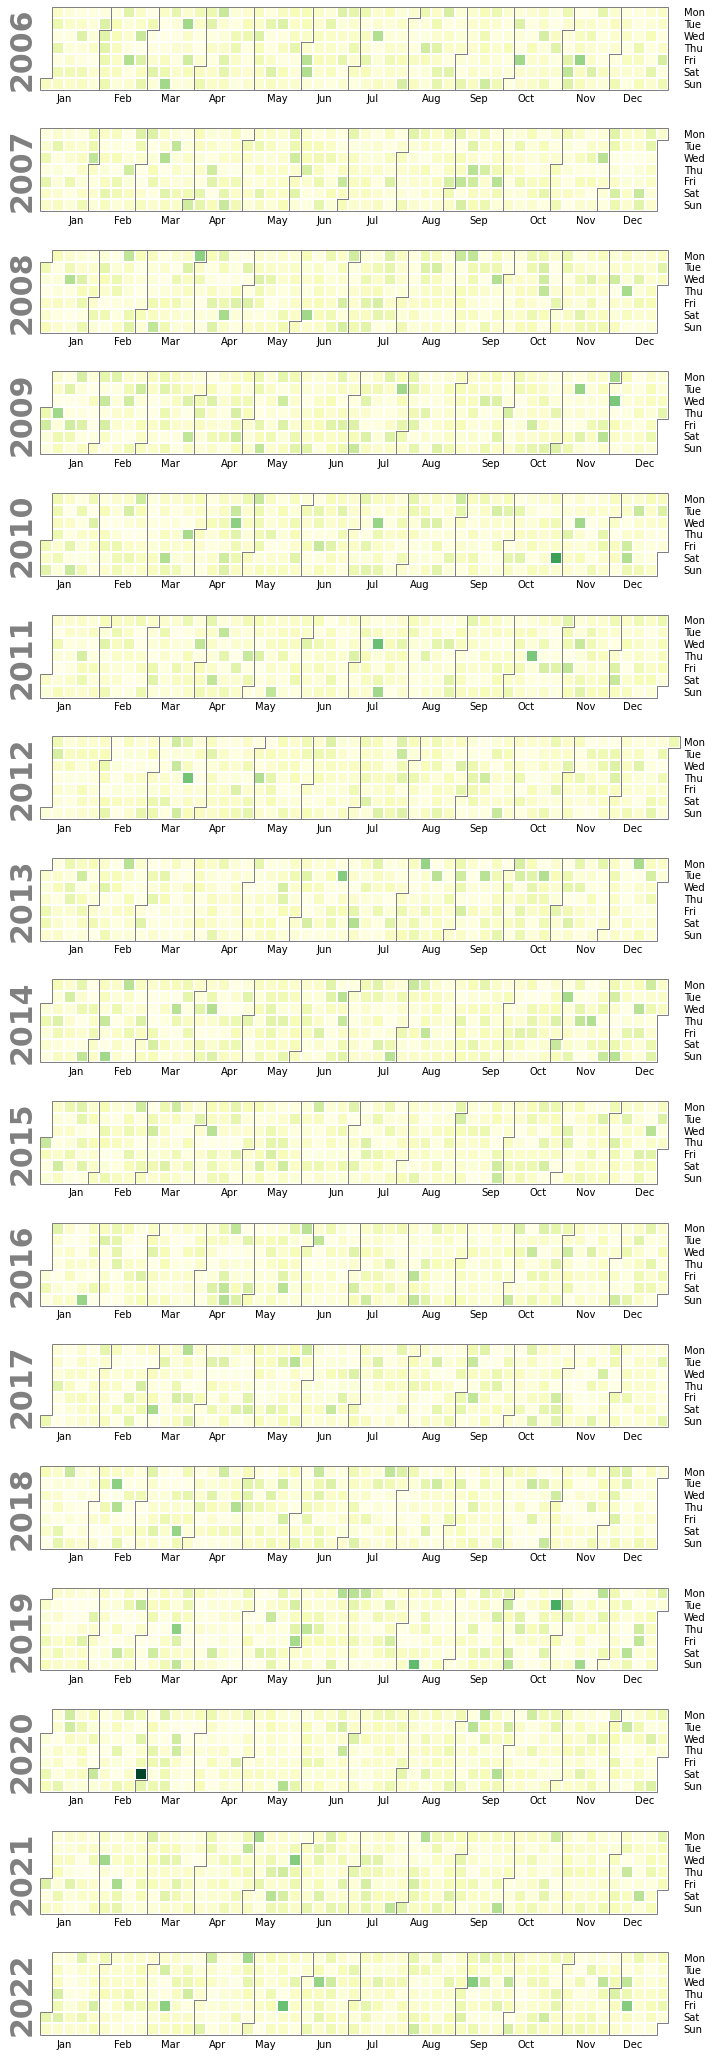

In [10]:
# Calendar plot
all_days = df_shooting.datetime.dt.date.unique().astype('datetime64')
counts = np.array(df_shooting.datetime.dt.date.value_counts().sort_index())
events = pd.Series(counts, index=all_days)
calplot.calplot(events, cmap='YlGn', colorbar=False);

We can see from the bar plot that most shooting incidents occur in the evening or during the night. The calendar plot highlights some dates where a lot of incidents occured, for example in December 2018 there are two consecutive days with a lot of incidents.

#### Location of incidents

We will first look at the location description to see in which kindd of setting shooting incidents are most common.

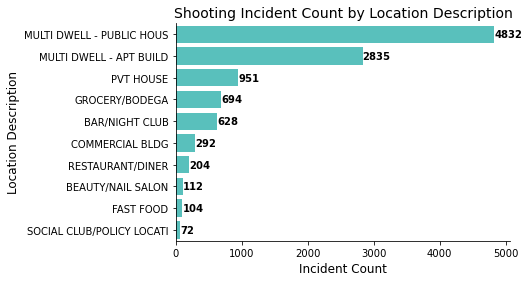

In [11]:
# Define the order of categories based on shooting incident count
incident_count = df_shooting['location_desc'].value_counts().nlargest(10)

# Create horizontal bar plot using Seaborn with the ordered groups
sns.barplot(x=incident_count.values, y=incident_count.index, color='mediumturquoise')

# Set plot title and axis labels
plt.title('Shooting Incident Count by Location Description', fontsize=14)
plt.xlabel('Incident Count', fontsize=12)
plt.ylabel('Location Description', fontsize=12)

# Remove top and right spines
sns.despine()

# Add value labels to bars
for index, value in enumerate(incident_count):
    plt.text(value, index, str(value), ha='left', va='center', fontweight='bold', color='black')

# Show plot
plt.show()

We can see that the majority of shooting incidents in NYC occur in public housing (offered as low-cost housing from the government) and apartments. After that it is areas such as bars, bodegas, and restaurants where most incidents occur.

#### Race, age and gender

We will now look into the distribution of the race, age, and gender of both the perpetrators and the victims. First of all we will investigate whether the age of the victim affects the chance that the shooting incident is a murder.

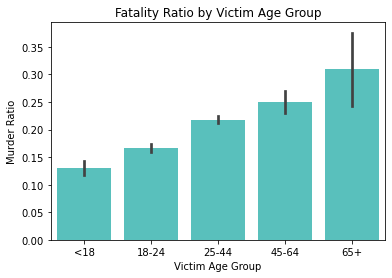

In [12]:
# Calculate murder ratios for each victim age group
murder_ratios = df_shooting.groupby('vic_age_group')['statistical_murder_flag'].mean()

# Sort the murder ratios by ascending order and get the corresponding VIC_AGE_GROUP values
ordered_groups = murder_ratios.sort_values().index.tolist()

# Create bar plot using Seaborn with the ordered groups
sns.barplot(x='vic_age_group', y='statistical_murder_flag', data=df_shooting, order=ordered_groups, color='mediumturquoise')

# Set plot title and axis labels
plt.title('Fatality Ratio by Victim Age Group')
plt.xlabel('Victim Age Group')
plt.ylabel('Murder Ratio')

# Show plot
plt.show()

We can see that there is a clear correlation here. The older the victim is, the higher the chance is that an incident becomes a murder.

We will now investigate the age, race and gender of perpetrators and victims.

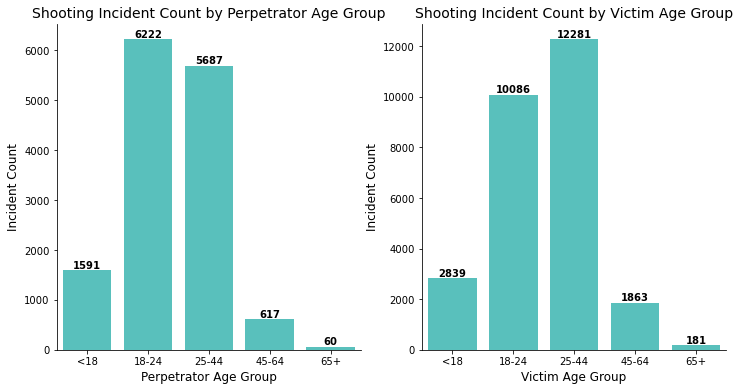

In [13]:
# Define the order of categories based on age group
age_order = ['<18', '18-24', '25-44', '45-64', '65+']

# Calculate shooting incident count for each perpetrator age group
incident_count = df_shooting.groupby('perp_age_group')['incident_key'].count().reindex(age_order)

# Create a grid of subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12,6))

# Create the first bar plot in the first subplot
sns.barplot(x=incident_count.index, y=incident_count.values, color='mediumturquoise', ax=axs[0])

# Set plot title and axis labels for the first subplot
axs[0].set_title('Shooting Incident Count by Perpetrator Age Group', fontsize=14)
axs[0].set_xlabel('Perpetrator Age Group', fontsize=12)
axs[0].set_ylabel('Incident Count', fontsize=12)

# Remove top and right spines for the first subplot
sns.despine(ax=axs[0])

# Add value labels to bars in the first subplot
for index, value in enumerate(incident_count):
    axs[0].text(index, value, str(value), ha='center', va='bottom', fontweight='bold', color='black')

# Calculate shooting incident count for each victim age group
incident_count_victim = df_shooting.groupby('vic_age_group')['incident_key'].count().reindex(age_order)

# Create the second bar plot in the second subplot
sns.barplot(x=incident_count_victim.index, y=incident_count_victim.values, color='mediumturquoise', ax=axs[1])

# Set plot title and axis labels for the second subplot
axs[1].set_title('Shooting Incident Count by Victim Age Group', fontsize=14)
axs[1].set_xlabel('Victim Age Group', fontsize=12)
axs[1].set_ylabel('Incident Count', fontsize=12)

# Remove top and right spines for the second subplot
sns.despine(ax=axs[1])

# Add value labels to bars in the second subplot
for index, value in enumerate(incident_count_victim):
    axs[1].text(index, value, str(value), ha='center', va='bottom', fontweight='bold', color='black')

# Show plot
plt.show()

Here we see that there are actually quite similar distributions of age groups of perpetrators and victims. The vast majority of both perpetrators and victims are in the age groups 18-24 and 25-44. When we look more into the ranges of the groups, we can see that 18-24 only contains 7 years, where as 25-44 and 45-64 both contains 20 years. For the <18 group it is likely that most people in this group are aged close to 17 (at least for the perpetrators, as a 2-year-old is not likely to shoot someone). With these considerations, it seems that young people are generally the ones involved in shooting incidents in NYC.

We will now look into the race of the perpetrators and victims:

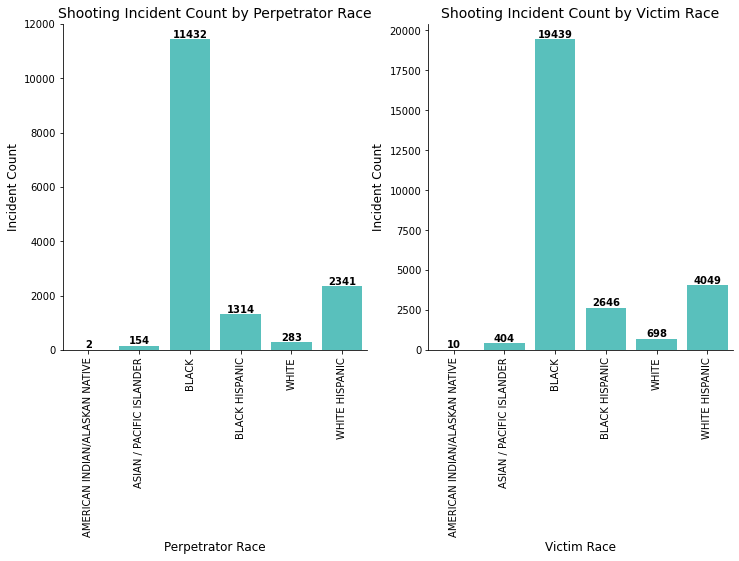

In [14]:
# Calculate shooting incident count for each perpetrator race
incident_count = df_shooting.groupby('perp_race')['incident_key'].count()

# Create a grid of subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12,6))

# Create the first bar plot in the first subplot
sns.barplot(x=incident_count.index, y=incident_count.values, color='mediumturquoise', ax=axs[0])

# Set plot title and axis labels for the first subplot
axs[0].set_title('Shooting Incident Count by Perpetrator Race', fontsize=14)
axs[0].set_xlabel('Perpetrator Race', fontsize=12)
axs[0].set_ylabel('Incident Count', fontsize=12)
axs[0].tick_params(axis='x', rotation=90)

# Remove top and right spines for the first subplot
sns.despine(ax=axs[0])

# Add value labels to bars in the first subplot
for index, value in enumerate(incident_count):
    axs[0].text(index, value, str(value), ha='center', va='bottom', fontweight='bold', color='black')

# Calculate shooting incident count for each victim race
incident_count_victim = df_shooting.groupby('vic_race')['incident_key'].count()

# Create the second bar plot in the second subplot
sns.barplot(x=incident_count_victim.index, y=incident_count_victim.values, color='mediumturquoise', ax=axs[1])

# Set plot title and axis labels for the second subplot
axs[1].set_title('Shooting Incident Count by Victim Race', fontsize=14)
axs[1].set_xlabel('Victim Race', fontsize=12)
axs[1].set_ylabel('Incident Count', fontsize=12)
axs[1].tick_params(axis='x', rotation=90)

# Remove top and right spines for the second subplot
sns.despine(ax=axs[1])

# Add value labels to bars in the second subplot
for index, value in enumerate(incident_count_victim):
    axs[1].text(index, value, str(value), ha='center', va='bottom', fontweight='bold', color='black')


# Show plot
plt.show()

Here we can again see that the distriburion of race is very similar for both the perpetrators and the victims. We are also interested in finding out if most of the incidents involve a perpetrator and victim of the same race, or different race.

The number of incidents where perpetrator and victim have the same race is 10615
The number of incidents where perpetrator and victim have different race is 4869


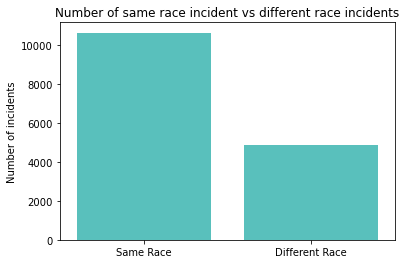

In [15]:
perp_vic_race = np.array(df_shooting[['perp_race','vic_race']].dropna())

same_race = 0
diff_race = 0
for i in perp_vic_race:
    if i[0] == i[1]:
        same_race += 1
    else:
        diff_race += 1
print(f'The number of incidents where perpetrator and victim have the same race is {same_race}')
print(f'The number of incidents where perpetrator and victim have different race is {diff_race}')

plt.figure()
sns.barplot(x=["Same Race", "Different Race"], y=[same_race,diff_race], color='mediumturquoise')
plt.title('Number of same race incident vs different race incidents')
plt.ylabel('Number of incidents')
plt.show()

We will look at the gender of the perpetrators and victims.

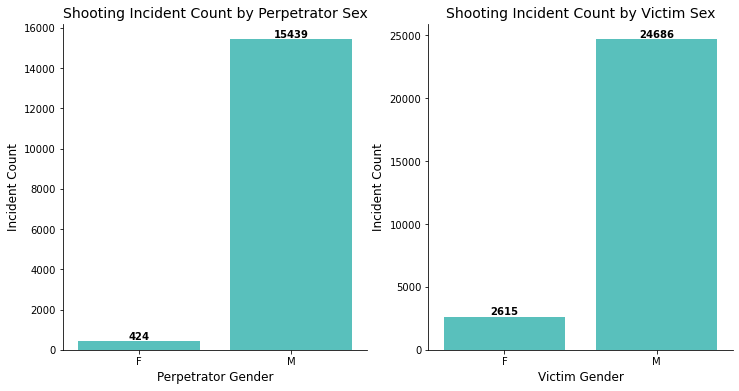

In [16]:
# Calculate shooting incident count for each perpetrator race
incident_count = df_shooting.groupby('perp_sex')['incident_key'].count()

# Create a grid of subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12,6))

# Create the first bar plot in the first subplot
sns.barplot(x=incident_count.index, y=incident_count.values, color='mediumturquoise', ax=axs[0])

# Set plot title and axis labels for the first subplot
axs[0].set_title('Shooting Incident Count by Perpetrator Sex', fontsize=14)
axs[0].set_xlabel('Perpetrator Gender', fontsize=12)
axs[0].set_ylabel('Incident Count', fontsize=12)

# Remove top and right spines for the first subplot
sns.despine(ax=axs[0])

# Add value labels to bars in the first subplot
for index, value in enumerate(incident_count):
    axs[0].text(index, value, str(value), ha='center', va='bottom', fontweight='bold', color='black')

# Calculate shooting incident count for each victim race
incident_count_victim = df_shooting.groupby('vic_sex')['incident_key'].count()

# Create the second bar plot in the second subplot
sns.barplot(x=incident_count_victim.index, y=incident_count_victim.values, color='mediumturquoise', ax=axs[1])

# Set plot title and axis labels for the second subplot
axs[1].set_title('Shooting Incident Count by Victim Sex', fontsize=14)
axs[1].set_xlabel('Victim Gender', fontsize=12)
axs[1].set_ylabel('Incident Count', fontsize=12)

# Remove top and right spines for the second subplot
sns.despine(ax=axs[1])

# Add value labels to bars in the second subplot
for index, value in enumerate(incident_count_victim):
    axs[1].text(index, value, str(value), ha='center', va='bottom', fontweight='bold', color='black')


# Show plot
plt.show()

Almost all the perpetrators are males, and most of the victims are males as well. There is, however, a larger proportion of female vitims than female perpetrators.

#### Shooting incidents by borough

We will now analyse shooting incident in each borough. First by looking at the race distribution of the perpetrators and victims in each borough. We will remove the 'AMERICAN INDIAN/ALASKAN NATIVE' since there are so few occurences of this race.

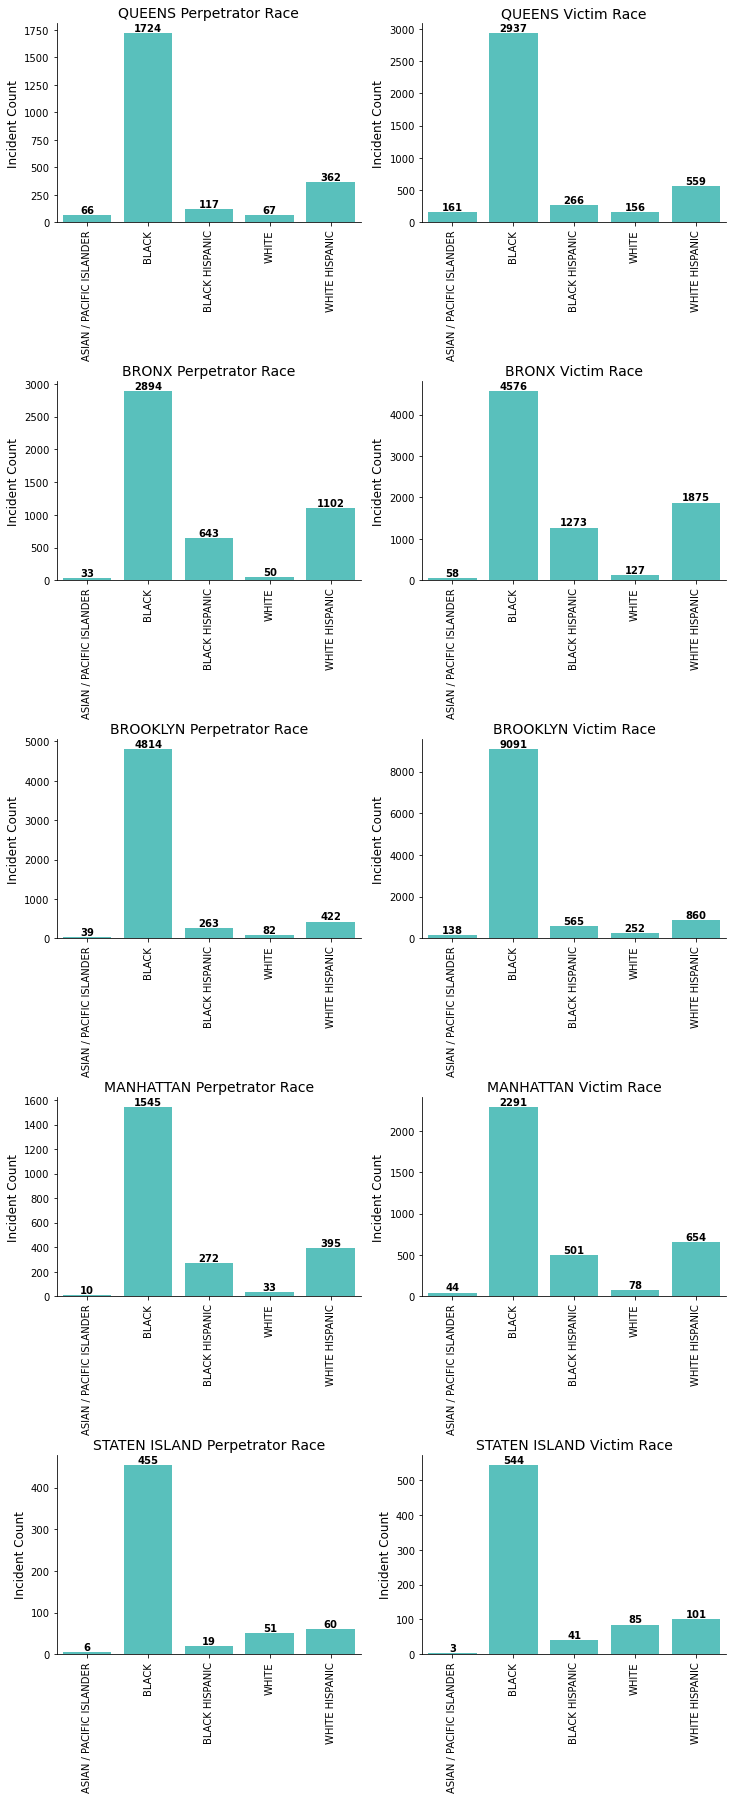

In [17]:
boroughs = df_shooting.boro.unique()
races = sorted(df_shooting.vic_race.dropna().unique())[1:]


# Create a grid of subplots with a row for each borough and 2 columns
fig, axs = plt.subplots(len(boroughs), 2, figsize=(12,30))
plt.subplots_adjust(hspace=0.8)

for i in range(len(boroughs)):
    
    df_temp = df_shooting[df_shooting.boro == boroughs[i]]
    
    # Calculate shooting incident count for each perpetrator race
    incident_count = df_temp.groupby('perp_race')['incident_key'].count().reindex(races)

    # Create the first bar plot in the first subplot
    sns.barplot(x=incident_count.index, y=incident_count.values, color='mediumturquoise', ax=axs[i,0])

    # Set plot title and axis labels for the first subplot
    axs[i,0].set_title(f'{boroughs[i]} Perpetrator Race', fontsize=14)
    axs[i,0].set_xlabel('')
    axs[i,0].set_ylabel('Incident Count', fontsize=12)
    axs[i,0].tick_params(axis='x', rotation=90)

    # Remove top and right spines for the first subplot
    sns.despine(ax=axs[i,0])

    # Add value labels to bars in the first subplot
    for index, value in enumerate(incident_count):
        axs[i,0].text(index, value, str(value), ha='center', va='bottom', fontweight='bold', color='black')

    # Calculate shooting incident count for each victim race
    incident_count_victim = df_temp.groupby('vic_race')['incident_key'].count().reindex(races)

    # Create the second bar plot in the second subplot
    sns.barplot(x=incident_count_victim.index, y=incident_count_victim.values, color='mediumturquoise', ax=axs[i,1])

    # Set plot title and axis labels for the second subplot
    axs[i,1].set_title(f'{boroughs[i]} Victim Race', fontsize=14)
    axs[i,1].set_xlabel('')
    axs[i,1].set_ylabel('Incident Count', fontsize=12)
    axs[i,1].tick_params(axis='x', rotation=90)

    # Remove top and right spines for the second subplot
    sns.despine(ax=axs[i,1])

    # Add value labels to bars in the second subplot
    for index, value in enumerate(incident_count_victim):
        axs[i,1].text(index, value, str(value), ha='center', va='bottom', fontweight='bold', color='black')

# Show plot
plt.show()

#### Location

Finally, we will do a heatmap over time to show where the shooting incidents occur.

In [18]:
# Get geo locations
geo={"lat": 40.730610 , "lon": -73.935242 }

# Create a list of day-wise data
df_year_list = []

# get a list of all the years
years = sorted(set(df_shooting.datetime.dt.year.unique()))

# Group the data by year and location
for year in years:
    df_year_list.append(df_shooting.loc[df_shooting.datetime.dt.year == year, ['latitude', 'longitude']].groupby(['latitude', 'longitude']).count().reset_index().values.tolist())

# Create a folium map object
map_hooray = folium.Map(location=[geo['lat'], geo['lon']], zoom_start=11, tiles="Stamen Toner")

# Create a list of location data
heat_data = [[row['latitude'], row['longitude']] for index, row in df_shooting.iterrows()]

# Add the heat map with time to the folium map object
HeatMapWithTime(df_year_list, name='test', auto_play=False, max_opacity=1,index=years).add_to(map_hooray)

map_hooray

# Save the map to a file
#map_hooray.save('my_map.html')

#### Summary of shooting incidents

From our initial data analysis section of shooting incidents, we have already started to see some patterns. First of all, it is clear to see that the vast majority of both perpetrators as well as victims are male, and the most common race, again for both perpetrator and victim, is black. Building on top of that, in most of the shooting incidents, the perpetator and victim are of the same ethnicity. Most shootings occur during the evening/night, and the older a victim is the higher the chance that the incident led to the victim being murdered. Furthermore, a heatmap showed that the boruoghs with the most shooting incident are Brooklyn and The Bronx.Finally, there was a downward trend in the number of shooting incidents from 2006 to 2019, however in 2020 the number of incidents shot right back up.

## 3. Data Analysis

We will now do some more in-depth analysis of the shooting incidents in New York City. We will look into how it effects various aspects of life in NYC, such as cinstruction work and school attendances.

### 3.1 School attendance

First, we will now look into how shooting incidents affect school attendance in New York City. We will start by creating a heatmap of average school attendances. We do that by taking the average attendaces of all time of each school, and plotting it on a map where green values show high attendance and red values show low attendance.

In [49]:
# Plot where schools are
school_list = school_df.copy()
school_list.drop_duplicates(subset=['school'], inplace=True)
print('Number of unique schools:', len(school_list))

# Get dataframe of average attendance of each school
average_attendance = school_df.groupby(['school','latitude','longitude'])['attendance'].mean()
average_attendance = average_attendance.reset_index()

# Define a color scale based on attendance percentage
color_scale = folium.LinearColormap(
    ['red', 'yellow', 'green'],
    vmin = 0.82,
    vmax = 1
)

# Create a folium map centered on the United States
map = folium.Map(location=[40.730610, -73.935242], zoom_start=11, tiles="Stamen Toner")

# Add a marker for each school with a color based on attendance percentage
for i, row in average_attendance.iterrows():
    color = color_scale(row['attendance']) # get color based on attendance percentage
    folium.CircleMarker(location=[row['latitude'], row['longitude']],
                        radius=8, # adjust size of circle marker as needed
                        color=color,
                        fill=True,
                        fill_color=color,
                        opacity=0,
                        fill_opacity=0.4).add_to(map)

# Add a color scale legend to the map
color_scale.add_to(map)

# Display the map
map.save('attendance_heatmap.html')
map

Number of unique schools: 1676


We can see that areas where there are generally low attendance in schools are Brooklyn and The Bronx. This actually reflects the heatmap in section 2 where we showed a heatmap of the number of shooting incidents - there Brooklyn and The Bronx were the areas with the most shooting incidents. This shows a negative correlation between the number of shooting incidents and attendance i.e. the more incident the less the attendance.

We now want to check if a shooting incident has an effect on school attendence on the day of the incident and the day after for nearby schools. We do so by taking the average attendace when there was a shooting incident within 1km og the school on the day or the day before, as well as the average attendance when there wasn't a shooting incident nearby.

To do so we first create a dictionary which has each unique school as the keys, and a list of all the dates where a shooting occured with 1km of the school as values. This takes a long time to run, so we have done that already and saved it as a pickle. We then add two columns of booleans to the `shootings_df`: `shooting_same_day` and `shooting_prev_day`, which state if there was a shooting nearby the school on the same day or the day before respectively. We then take the average attendance for when there was a shooting nearby on the same day or day before, and the average attendance when there wasn't a shooting.

In [20]:
'''Takes a long time

# define start and end dates
start_date = pd.to_datetime('2006-09-05')
end_date = pd.to_datetime('2017-06-28')
df_shooting = df_shooting.loc[(df_shooting['datetime'] >= start_date) & (df_shooting['datetime'] <= end_date)]

# Make a dictionary to get all dates where a shooting occurred within 1 km for each school
# Takes a long time to run - have saved result in a pickle
shootings = {}

# define a function to calculate distance between two points
def get_distance(lat1, lon1, lat2, lon2):
    return distance((lat1, lon1), (lat2, lon2)).km

# loop over each row of the attendance dataframe and get list of dates with shootings within 1km
i = 0
for idx, row in school_list.iterrows():
    i += 1
    school_lat = row['latitude']
    school_lon = row['longitude']
    dates_with_shootings = []
    for idx2, row2 in df_shooting.iterrows():
        shooting_lat = row2['latitude']
        shooting_lon = row2['longitude']
        shooting_date = row2['date']
        dist = get_distance(school_lat, school_lon, shooting_lat, shooting_lon)
        # if dist <= 1 and shooting_date not in dates_with_shootings:
        if dist <= 1:
            dates_with_shootings.append(shooting_date)
    shootings[row['school']] = dates_with_shootings
    if i%10 == 0:
        print(i)
'''

# Load
with open('shooting_school.pickle', 'rb') as handle:
    shootings = pickle.load(handle)

In [21]:
# Add boolean column for shooting incident on same day and day before (takes a few minutes to run)
school_df['shooting_same_day'] = school_df.apply(lambda row: row['date'] in shootings[row['school']], axis=1)
school_df['shooting_prev_day']=school_df.apply(lambda row: row['date']-pd.Timedelta(days=1) in shootings[row['school']], axis=1)

school_with_shooting = school_df[(school_df['shooting_same_day']) | (school_df['shooting_prev_day'])]
school_without_shooting = school_df[~(school_df['shooting_same_day'] | school_df['shooting_prev_day'])]

print('Average attendance based on all attendances')
with_shooting_mean = school_with_shooting.present.sum()/school_with_shooting.enrolled.sum()
without_shooting_mean = school_without_shooting.present.sum()/school_without_shooting.enrolled.sum()
print(f'When there was a shooting incident within 1km same day or day before: {100*with_shooting_mean}')
print(f'When there was no shooting incident within 1km same day or day before: {100*without_shooting_mean}')

print('\nAverage attendance based on school')
with_shooting_mean = school_with_shooting.attendance.mean()
without_shooting_mean = school_without_shooting.attendance.mean()
print(f'When there was a shooting incident within 1km same day or day before: {100*with_shooting_mean}')
print(f'When there was no shooting incident within 1km same day or day before: {100*without_shooting_mean}')

Average attendance based on all attendances
When there was a shooting incident within 1km same day or day before: 88.76784809034535
When there was no shooting incident within 1km same day or day before: 90.67410160605628

Average attendance based on school
When there was a shooting incident within 1km same day or day before: 87.95778639369665
When there was no shooting incident within 1km same day or day before: 89.6994185626475


We can see that the average attendance is about 2% lower when there was a shooting nearby on the same day or the day before. So again, it seems that it does effect the attendance if there has been a shooting incident nearby.

Below are some plots showing the average attendance over all schools in New York City. Some of them have also plotted the number of shooting, to see if there are any correlations.

In [22]:
# # Plot
# schools = list(school_list.school.unique())
# individual_schools = school_df.groupby('school')
# for i in range(5):
#     fig, ax = plt.subplots(figsize=(10, 5))
#     temp = individual_schools.get_group(schools[i])
#     temp.plot(x='date', y='attendance', legend=False, ax=ax)
#     ax.set_xlabel("Date")
#     ax.set_ylabel("Attendance %")
#     ax.scatter(shootings[schools[i]], 0.9*np.ones(len(shootings[schools[i]])), marker='x', color='red', zorder=10)
#     ax.set_xlim(temp.date.min(), temp.date.max())
#     plt.show()

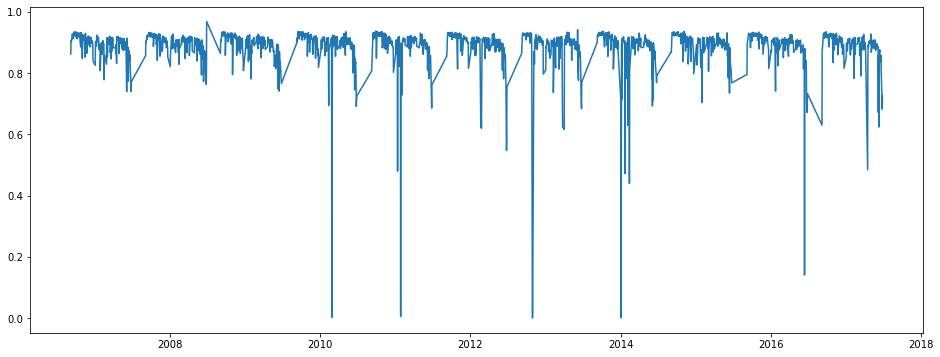

In [23]:
# Plot average attendance for all of new schools in NYC
daily_attendances = school_df.groupby('date')['attendance'].mean()
plt.figure(figsize=(16,6))
plt.plot(daily_attendances)
plt.show()

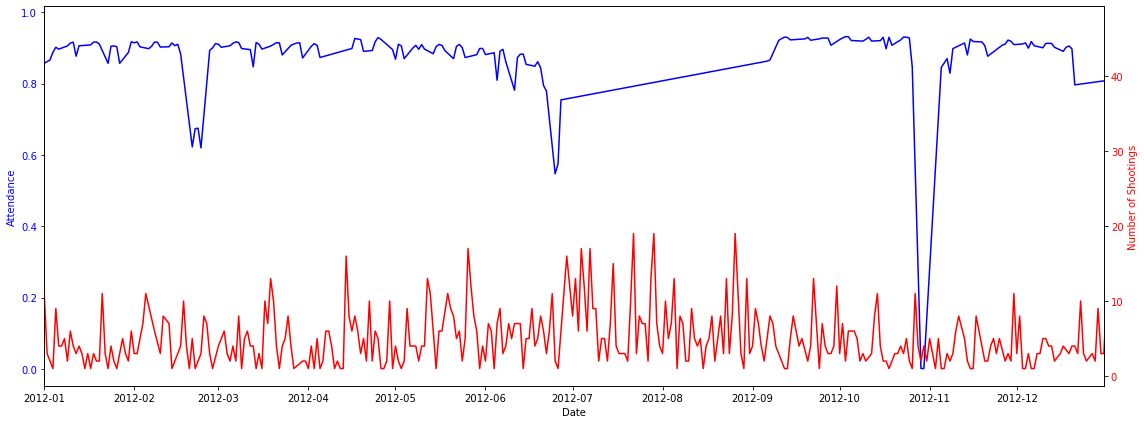

In [24]:
daily_attendances = school_df.groupby('date')['attendance'].mean()
daily_shootings = df_shooting.groupby('date')['incident_key'].count()

fig, ax1 = plt.subplots(figsize=(16,6))
ax1.plot(daily_attendances, color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Attendance', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(daily_shootings, color='red')
ax2.set_ylabel('Number of Shootings', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax1.set_xlim(pd.Timestamp('2012-01-01'), pd.Timestamp('2012-12-31'))
fig.tight_layout()
plt.show()

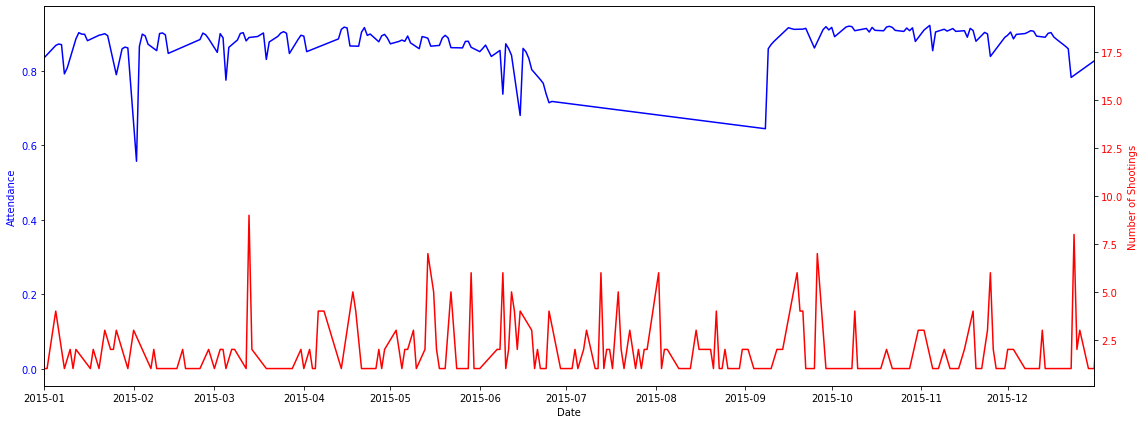

In [25]:
daily_attendances = school_df[school_df.borough == 'X'].groupby('date')['attendance'].mean()
daily_shootings = df_shooting[df_shooting.boro == 'BRONX'].groupby('date')['incident_key'].count()

fig, ax1 = plt.subplots(figsize=(16,6))
ax1.plot(daily_attendances, color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Attendance', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(daily_shootings, color='red')
ax2.set_ylabel('Number of Shootings', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax1.set_xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2015-12-31'))
fig.tight_layout()
plt.show()

We will now look into the z-scored of the school attendances

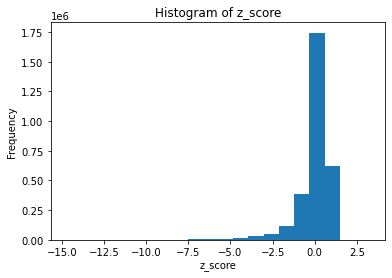

In [26]:
# extract the z-scores from the school dataframe
z_scores = school_df['z_score']

# create a histogram of the z-scores
plt.hist(z_scores, bins=20)
plt.xlabel('z_score')
plt.ylabel('Frequency')
plt.title('Histogram of z_score')
plt.show()

In [27]:
public_places=['GROCERY/BODEGA', 'BAR/NIGHT CLUB', 'COMMERCIAL BLDG',
       'RESTAURANT/DINER', 'BEAUTY/NAIL SALON', 'FAST FOOD',
       'SOCIAL CLUB/POLICY LOCATI', 'GAS STATION', 'HOSPITAL', 'LIQUOR STORE',
       'SMALL MERCHANT', 'STORE UNCLASSIFIED', 'HOTEL/MOTEL',
       'DRY CLEANER/LAUNDRY', 'SUPERMARKET', 'DRUG STORE', 'CLOTHING BOUTIQUE',
       'JEWELRY STORE', 'TELECOMM. STORE', 'VARIETY STORE', 'SHOE STORE',
       'DEPT STORE', 'FACTORY/WAREHOUSE', 'VIDEO STORE', 'CANDY STORE',
       'CHAIN STORE', 'GYM/FITNESS FACILITY', 'BANK', 'DOCTOR/DENTIST', 'ATM',
       'SCHOOL', 'LOAN COMPANY', 'PHOTO/COPY STORE', 'CHECK CASH',
       'STORAGE FACILITY']

In [28]:
# Create a copy of the original df
shootings_df = df_shooting.copy()

# Only public shootings
shootings_df['shooting_in_public'] = (shootings_df['location_desc'].isin(public_places))

# Only select columns
shootings_df = shootings_df[['incident_key','latitude','longitude','date','shooting_in_public']]

# Get a list of schools and drop nan coordinates
school_df_aux = school_df.drop_duplicates(subset='school')
shootings_df.dropna(subset=['latitude','longitude'],inplace=True)
school_df_aux.dropna(subset=['latitude','longitude'],inplace=True)

# create pairwise distance matrix
distances = cdist(shootings_df[['latitude', 'longitude']], school_df_aux[['latitude', 'longitude']])

# find index of minimum distance for each row in df1
min_idx = np.argmin(distances, axis=1)
min_dist = np.min(distances, axis=1)

min_dist_km = [geodesic((shootings_df.iloc[i]['latitude'], shootings_df.iloc[i]['longitude']), (school_df_aux.iloc[min_idx[i]]['latitude'], school_df_aux.iloc[min_idx[i]]['longitude'])).km for i in range(len(shootings_df))]

# add nearest id to df1
shootings_df['nearest_id'] = school_df_aux.iloc[min_idx]['school'].values
shootings_df['distance']=min_dist_km
shootings_df = shootings_df.merge(school_df[['school', 'date', 'z_score','attendance','released']],
                                  left_on=['nearest_id', 'date'], right_on=['school', 'date']).drop(['school'], axis=1)

shootings_df['date_plus1']=shootings_df['date']+ BDay(1)
shootings_df = shootings_df.merge(school_df[['school', 'date','z_score','attendance','released']],
                                  left_on=['nearest_id', 'date_plus1'],
                                  right_on=['school', 'date'],
                                  suffixes=(None,'_nextday'))#.drop(['school','date'], axis=1)

shootings_df.drop_duplicates(inplace=True)

shootings_df.head()

incident_key   latitude  longitude       date  shooting_in_public  \
0     71662474  40.694264 -73.932809 2010-03-08               False   
4     78961869  40.884495 -73.905599 2011-05-25               False   
5     87694905  40.678205 -73.923188 2012-11-14               False   
6     34979907  40.887451 -73.847608 2007-10-11               False   
8     78644238  40.846155 -73.899250 2011-05-09               False   

  nearest_id  distance   z_score  attendance  released date_plus1  school  \
0     16K026  0.254299  0.162709    0.922636       0.0 2010-03-09  16K026   
4     10X007  0.381295  0.475492    0.952830       0.0 2011-05-26  10X007   
5     16K040  0.262694 -0.249520    0.858086       0.0 2012-11-15  16K040   
6     11X112  0.460503  0.226772    0.943274       0.0 2007-10-12  11X112   
8     09X058  0.001461 -0.384716    0.856833       0.0 2011-05-10  09X058   

  date_nextday  z_score_nextday  attendance_nextday  released_nextday  
0   2010-03-09         0.281850            0.939828               0.0  
4   2011-05-26         0.515179            0.950943               0.0  
5   2012-11-15         0.601696            0.973597               0.0  
6   2007-10-12         0.389386            0.925446               0.0  
8   2011-05-10        -0.023511            0.909091               0.0

In [29]:
school_df.z_score.mean(),school_df.attendance.mean()

(-3.066270850889614e-15, 0.8961071926602494)

In [30]:
shootings_df.z_score.mean(),shootings_df.z_score_nextday.mean(),shootings_df.attendance.mean()

(0.0525035108929993, 0.03961615000811214, 0.9012736051889423)

In [31]:
shootings_df[shootings_df.shooting_in_public==True].z_score.mean(),shootings_df[shootings_df.shooting_in_public==True].z_score_nextday.mean(),shootings_df[shootings_df.shooting_in_public==True].attendance.mean()

(0.036784512125594304, 0.011562483521246855, 0.9028232364049603)

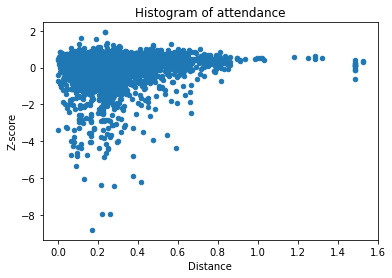

In [32]:
# create a scatter plot of distance vs z_score
shootings_df.plot(kind='scatter', x='distance', y='z_score')

# set the x and y axis labels
plt.xlabel('Distance')
plt.ylabel('Z-score')
plt.title('Histogram of attendance')
# display the plot
plt.show()

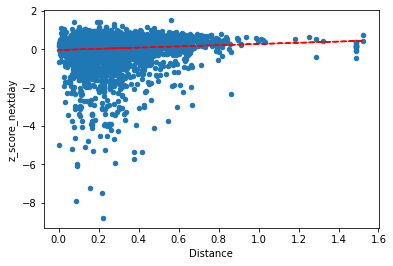

In [33]:
# create a scatter plot of distance vs z_score
shootings_df.plot(kind='scatter', x='distance', y='z_score_nextday')

# calculate the best-fit line using numpy's polyfit function
x = shootings_df['distance']
y = shootings_df['z_score_nextday']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

# plot the best-fit line
plt.plot(x,p(x),"r--")

# set the x and y axis labels
plt.xlabel('Distance')
plt.ylabel('z_score_nextday')

# display the plot
plt.show()

In [34]:
school_df2 = school_df.copy()
school_df2 = school_df2.merge(shootings_df[['nearest_id','date']],
                             left_on=['school','date'],
                             right_on=['nearest_id','date'],
                             how='left')
school_df2 = school_df2.merge(shootings_df[['nearest_id','date_plus1']],
                              left_on=['school','date'],
                              right_on=['nearest_id','date_plus1'],
                              suffixes=(None,'_nextday'),
                              how='left')
school_df2['shooting'] = school_df2['nearest_id'].notnull() | school_df2['nearest_id_nextday'].notnull()
school_df2.drop(['nearest_id','date','nearest_id_nextday','date_plus1'],axis=1,inplace=True)
school_df2.head()

school  schoolyear  enrolled  present  absent  released  longitude  \
0  01M015    20062007     252.0    226.0    26.0       0.0 -73.979022   
1  01M019    20062007     323.0    290.0    33.0       0.0 -73.983818   
2  01M020    20062007     650.0    605.0    45.0       0.0 -73.986648   
3  01M034    20062007     376.0    325.0    51.0       0.0 -73.975181   
4  01M063    20062007     210.0    193.0    17.0       0.0 -73.986381   

    latitude  month borough  attendance      mean       std   z_score  \
0  40.721807      9       M    0.896825  0.862151  0.096213  0.360397   
1  40.729636      9       M    0.897833  0.862151  0.096213  0.370868   
2  40.721540      9       M    0.930769  0.862151  0.096213  0.713197   
3  40.726473      9       M    0.864362  0.862151  0.096213  0.022981   
4  40.724117      9       M    0.919048  0.862151  0.096213  0.591367   

   shooting_same_day  shooting_prev_day  shooting  
0              False              False     False  
1              False              False     False  
2              False              False     False  
3              False              False     False  
4              False              False     False

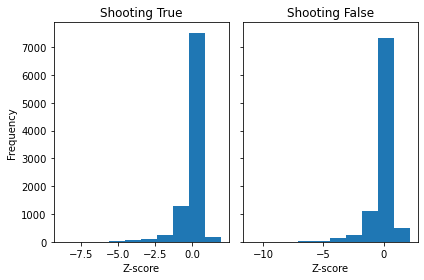

In [35]:
# create two sub-dataframes for when shooting is true and when it is false
shooting_true = school_df2[school_df2['shooting'] == True]
shooting_false = school_df2[school_df2['shooting'] == False]
shooting_false = shooting_false.sample(n=shooting_true.shape[0], random_state=42)


# create a figure with two subplots
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# plot the histograms for z_score when shooting is true and false in the respective subplots
axs[0].hist(shooting_true['z_score'])
axs[1].hist(shooting_false['z_score'])

# set the titles for each subplot
axs[0].set_title('Shooting True')
axs[1].set_title('Shooting False')

# set the x and y axis labels
axs[0].set_xlabel('Z-score')
axs[1].set_xlabel('Z-score')
axs[0].set_ylabel('Frequency')

# display the plot
plt.show()

In [36]:
shooting_true.z_score.mean(),shooting_false.z_score.mean()

(0.045873803723356116, -0.00435094668502583)

In [37]:
len(shooting_true),len(shooting_false)

(9388, 9388)

## 3.2 Construction

We will look into the effects shooting incidents have on construction in New York City. We will see if there is being investigated less in areas where there are more shootings. First, we will map the city into grids of roughly 1km by 1km. We will then count the number of shooting in each grid, and the total amount of money invested within that grid, and plot them against eac other to see if we can find any patterns.

<AxesSubplot:xlabel='Incident_count', ylabel='total_est__fee'>

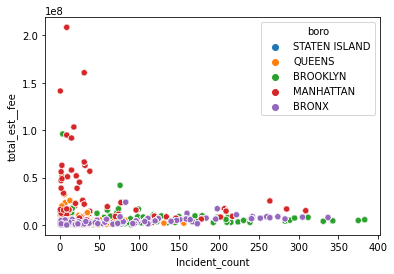

In [38]:
#Loading the shooting dataset
shootings_df=df_shooting.copy()

# Define step sizes for latitude and longitude
stepsize_lat = 0.009 # Roughly, 1 kilometer
stepsize_lon = 0.012 # Roughly, 1 kilometer

# Calculate minimum and maximum values for latitude and longitude across both dataframes
latmin = min(shootings_df.latitude.min(), construction_df.gis_latitude.min())
lonmin = min(shootings_df.longitude.min(), construction_df.gis_longitude.min())
lonmax = max(shootings_df.longitude.max(), construction_df.gis_longitude.max())
latmax = max(shootings_df.latitude.max(), construction_df.gis_latitude.max())

# Calculate number of rows and columns in the grid based on the step sizes and range of latitude and longitude
num_rows = int((latmax - latmin) / stepsize_lat) + 1
num_cols = int((lonmax - lonmin) / stepsize_lon) + 1

# Define a function to get the grid number for a given latitude and longitude
def get_grid_number(latitude, longitude, stepsize_lat=stepsize_lat, stepsize_lon=stepsize_lon, latmin=latmin, lonmin=lonmin):
    # Calculate row and column numbers based on the latitude and longitude values
    row = int((latitude - latmin) / stepsize_lat)
    col = int((longitude - lonmin) / stepsize_lon)
    # Calculate the grid number based on the row and column numbers
    grid_number = row * num_cols + col
    return grid_number

# Drop rows with missing latitude and longitude values in dfs
shootings_df.dropna(subset=['latitude', 'longitude'], inplace=True)
construction_df.dropna(subset=['gis_latitude', 'gis_longitude'], inplace=True)

# Map each row in shootings_df and construction_df to a grid cell number using the get_grid_number function
shootings_df['grid_number'] = shootings_df.apply(lambda row: get_grid_number(row['latitude'], row['longitude'], stepsize_lat, stepsize_lon, latmin, lonmin), axis=1)
construction_df['grid_number'] = construction_df.apply(lambda row: get_grid_number(row['gis_latitude'], row['gis_longitude'], stepsize_lat, stepsize_lon, latmin, lonmin), axis=1)

# Remove columns and group by grid_number to get count of incidents in each grid
shootings_df_ = shootings_df[['incident_key', 'grid_number']]
shootings_df_ = shootings_df_.groupby('grid_number').count()['incident_key'].reset_index()

# Merge with original dataframe to add 'boro' column back
shootings_df = shootings_df_.merge(shootings_df[['boro', 'grid_number']], on='grid_number', how='left')

# Rename 'incident_key' column to 'Incident_count'
shootings_df.rename(columns={'incident_key': 'Incident_count'}, inplace=True)

# Group construction_df by grid_number and get sum of 'total_est__fee'
construction_df_total = construction_df[['total_est__fee', 'borough', 'grid_number']].groupby('grid_number').sum()

# Merge shootings_df with construction_df_total on 'grid_number'
shootings_df = pd.merge(shootings_df, construction_df_total, on='grid_number', how='left')

sns.scatterplot(data=shootings_df, x='Incident_count', y='total_est__fee',hue='boro')

We can see that the grid with the most investments are in the places with the least shooting count! Furthermore, we can see that those grids are usually located in Manhattan. This makes sense, because when you go to New York you can easily see that Manhatten is the place with all the massive sky-scrapers and expenseive buildings. In adittion, Bronx is usually at the bottom of total money invested, and we can also see that there are sevral grids in Bronx with a lot of shooting incidents.

In addition, we can see that for some of the grids located in Manhattan and Brooklyn where the number of incidents is high, the total investment is relatively low. 

However, the reality is more complex than that, and it is very likely that the shootings incidents are not the only factor affecting the total investments. Are the shootings a cause of lower investment and lower social development indices? or is it the other way around?

We will now make a heatmap of the grids, where the more green a grid is the more money is being invested in it.

In [48]:
# Get dataframe of average fee of each grid
average_fee_ = construction_df[['grid_number','gis_latitude','gis_longitude']].drop_duplicates(subset=['grid_number'])
average_fee = construction_df[['grid_number','gis_latitude','gis_longitude','total_est__fee']].groupby(['grid_number'])['total_est__fee'].mean().reset_index()
average_fee=pd.merge(average_fee,average_fee_,on='grid_number',how='left')

# Define a color scale based on fee
color_scale = folium.LinearColormap(
    ['red', 'yellow', 'green'],
    vmin = average_fee.total_est__fee.min(),
    vmax = average_fee.total_est__fee.quantile(0.80)
)

# Create a folium map centered on New York City
mapa = folium.Map(location=[40.730610, -73.935242], zoom_start=11.4, tiles="Stamen Toner", 
                  attr="<a href=https://stamen.com>Stamen Design</a>")

# Add a marker for each grid with a color based on fee
for i, row in average_fee.iterrows():
    color = color_scale(row['total_est__fee']) # get color based on fee
    folium.CircleMarker(location=[row['gis_latitude'], row['gis_longitude']],
                        radius=5, # adjust size of circle marker as needed
                        color=color,
                        fill=True,
                        fill_color=color,
                        opacity=0,
                        fill_opacity=0.8).add_to(mapa)

# Add a color scale legend to the map
color_scale.add_to(mapa)

# Display the map
mapa.save('construction_heatmap.html')
mapa

## 3.3 Bike

We will now analyse the effects of shooting incidents on the bike dataset.

In [40]:
# Get dataframe of average usage of each bike station
average_usage = bike_df.groupby(['id','latitude','longitude'])['counts'].count()
average_usage = average_usage.reset_index()

# Define a color scale based on usage percentage
color_scale = folium.LinearColormap(
    ['red', 'yellow', 'green'],
    vmin = average_usage.counts.min(), # set the minimum value for the color scale
    vmax = average_usage.counts.max()  # set the maximum value for the color scale
)

# Create a folium map centered on the biking area
map = folium.Map(location=[40.7202, -73.9129], zoom_start=12, tiles="Stamen Toner")

# Add a marker for each bike station with a color based on usage percentage
for i, row in average_usage.iterrows():
    color = color_scale(row['counts']) # get color based on usage percentage
    folium.CircleMarker(location=[row['latitude'], row['longitude']],
                        radius=10, # adjust size of circle marker as needed
                        color=color,
                        fill=True,
                        fill_color=color,
                        opacity=0,
                        fill_opacity=0.8).add_to(map)

# Add a color scale legend to the map
color_scale.add_to(map)

# Display the map
map

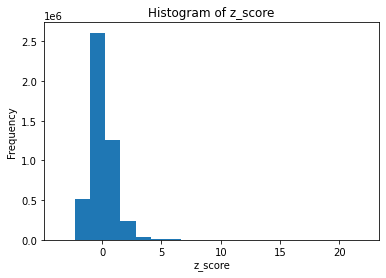

In [41]:
# Formatting for later merging
bike_df['date_aux'] = pd.to_datetime(bike_df['date']).dt.date
bike_df['date_aux'] = bike_df['date_aux'].astype('datetime64[ns]')

# Formatting and variable creation for later merging
bike_df['date'] = pd.to_datetime(bike_df['date'])

# calculate the 15-minute frame of the week (from 0 to 672) for each row in the bike dataframe and store it in a new column called '15_min_frame_week'
bike_df['15_min_frame_week'] = bike_df['date'].dt.weekday * 96 + bike_df['date'].dt.hour * 4 + bike_df['date'].dt.minute / 15

# group the bike dataframe by 'id' and '15_min_frame_week', and calculate the mean and standard deviation of the 'counts' column for each group
grouped_df = bike_df.groupby(['id', '15_min_frame_week'])['counts'].agg(['mean', 'std']).reset_index()

# merge the mean and standard deviation values back into the bike dataframe using the 'id' and '15_min_frame_week' columns
bike_df = pd.merge(bike_df, grouped_df, on=['id', '15_min_frame_week'])

# calculate the z-score for each row in the bike dataframe using the mean and standard deviation values for that row's 'id' and '15_min_frame_week'
bike_df['z_score_bike'] = (bike_df['counts'] - bike_df['mean']) / bike_df['std']

# extract the 'z_score_bike' column from the bike dataframe and store it in a variable called 'z_scores'
z_scores = bike_df['z_score_bike']

# generate a histogram of the z-scores using the matplotlib library
plt.hist(z_scores, bins=20)

# add labels and a title to the histogram
plt.xlabel('z_score')
plt.ylabel('Frequency')
plt.title('Histogram of z_score')

# display the histogram
plt.show()

In [42]:
public_places=['GROCERY/BODEGA', 'BAR/NIGHT CLUB', 'COMMERCIAL BLDG',
       'RESTAURANT/DINER', 'BEAUTY/NAIL SALON', 'FAST FOOD',
       'SOCIAL CLUB/POLICY LOCATI', 'GAS STATION', 'HOSPITAL', 'LIQUOR STORE',
       'SMALL MERCHANT', 'STORE UNCLASSIFIED', 'HOTEL/MOTEL',
       'DRY CLEANER/LAUNDRY', 'SUPERMARKET', 'DRUG STORE', 'CLOTHING BOUTIQUE',
       'JEWELRY STORE', 'TELECOMM. STORE', 'VARIETY STORE', 'SHOE STORE',
       'DEPT STORE', 'FACTORY/WAREHOUSE', 'VIDEO STORE', 'CANDY STORE',
       'CHAIN STORE', 'GYM/FITNESS FACILITY', 'BANK', 'DOCTOR/DENTIST', 'ATM',
       'SCHOOL', 'LOAN COMPANY', 'PHOTO/COPY STORE', 'CHECK CASH',
       'STORAGE FACILITY']

In [43]:
# Create a copy of the original df
shootings_df=df_shooting.copy()

shootings_df['shooting_in_public']=(shootings_df['location_desc'].isin(public_places))

shootings_df=shootings_df[['incident_key','latitude','longitude','date','shooting_in_public','datetime']]
shootings_df['latitude']=shootings_df['latitude'].astype(float)
shootings_df['longitude']=shootings_df['longitude'].astype(float)

shootings_df['15_min_frame_week'] = round(shootings_df['date'].dt.weekday*96 + shootings_df['datetime'].dt.hour*4 + shootings_df['datetime'].dt.minute/15)
shootings_df['15_min_frame_week']=shootings_df['15_min_frame_week'].astype(float)

bike_df_aux=count_location.drop_duplicates(subset='id')
shootings_df.dropna(subset=['latitude','longitude'],inplace=True)
bike_df_aux.dropna(subset=['latitude','longitude'],inplace=True)
# create pairwise distance matrix
distances = cdist(shootings_df[['latitude', 'longitude']], bike_df_aux[['latitude', 'longitude']])

# find index of minimum distance for each row in df1
min_idx = np.argmin(distances, axis=1)
min_dist = np.min(distances, axis=1)

min_dist_km = [geodesic((shootings_df.iloc[i]['latitude'], shootings_df.iloc[i]['longitude']), (bike_df_aux.iloc[min_idx[i]]['latitude'], bike_df_aux.iloc[min_idx[i]]['longitude'])).km for i in range(len(shootings_df))]

# add nearest id to df1
shootings_df['nearest_id'] = bike_df_aux.iloc[min_idx]['id'].values
shootings_df['distance']=min_dist_km
shooting_df_2=shootings_df[shootings_df['distance']<1]

from datetime import timedelta
shooting_df_2['15_min_frame_week_plus1'] = (shooting_df_2['15_min_frame_week'] + 1) % 672

shooting_df_2 = shooting_df_2.merge(bike_df[['id', 'counts', 'z_score_bike','15_min_frame_week','date_aux']], left_on=['nearest_id', '15_min_frame_week','date'], right_on=['id', '15_min_frame_week','date_aux'],how='left',suffixes=(None,'_bike')).drop(['id'], axis=1)
shooting_df_2 = shooting_df_2.merge(bike_df[['id', 'counts', 'z_score_bike','15_min_frame_week','date_aux']], left_on=['nearest_id', '15_min_frame_week_plus1','date'], right_on=['id', '15_min_frame_week','date_aux'],how='left',suffixes=(None,'_next15min')).drop(['id','15_min_frame_week_next15min','15_min_frame_week_plus1','nearest_id','date_aux','date_aux_next15min'], axis=1)
shooting_df_2.drop_duplicates(inplace=True)
shooting_df_2.dropna(subset=['counts'],inplace=True)
shooting_df_2

incident_key   latitude  longitude       date  shooting_in_public  \
2       140340393  40.695368 -73.983242 2014-12-28               False   
11      234208836  40.789310 -73.973838 2021-09-28               False   
13      199247701  40.755442 -73.943422 2019-07-03               False   
26      222524733  40.754018 -73.948391 2021-01-01               False   
36      199900180  40.754164 -73.944653 2019-07-17               False   
...           ...        ...        ...        ...                 ...   
1526    250682059  40.814715 -73.924507 2022-09-06               False   
1527    250897909  40.737683 -73.852048 2022-09-10               False   
1529    248390240  40.755434 -73.943421 2022-07-22               False   
1532    238998457  40.752036 -73.942721 2022-01-11               False   
1537    252032641  40.812289 -73.923499 2022-10-04               False   

                datetime  15_min_frame_week  distance  counts  z_score_bike  \
2    2014-12-28 19:53:00              656.0  0.534988     7.0     -1.063472   
11   2021-09-28 20:40:00              179.0  0.206029    23.0      0.286588   
13   2019-07-03 00:04:00              192.0  0.552522    33.0      0.647248   
26   2021-01-01 00:16:00              385.0  0.749199     7.0     -1.203381   
36   2019-07-17 16:38:00              259.0  0.498613    72.0     -0.127245   
...                  ...                ...       ...     ...           ...   
1526 2022-09-06 15:50:00              159.0  0.851666    39.0     -0.253863   
1527 2022-09-10 13:59:00              536.0  0.883342     3.0     -0.272012   
1529 2022-07-22 01:43:00              391.0  0.551639    13.0      1.151053   
1532 2022-01-11 14:45:00              155.0  0.223092    29.0     -0.696354   
1537 2022-10-04 17:22:00              165.0  0.587071    63.0      0.357715   

      counts_next15min  z_score_bike_next15min  
2                 11.0               -0.769435  
11                15.0               -0.401356  
13                18.0               -0.304049  
26                17.0               -0.222805  
36                81.0                0.084448  
...                ...                     ...  
1526              36.0               -0.502307  
1527               5.0                0.424075  
1529              16.0                2.203904  
1532              28.0               -0.771564  
1537              58.0                0.229957  

[169 rows x 12 columns]

<AxesSubplot:xlabel='distance', ylabel='z_score_bike'>

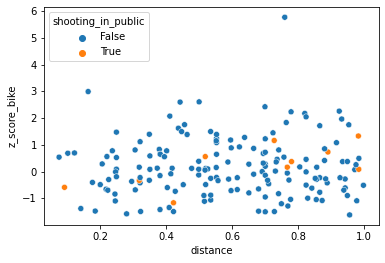

In [44]:
sns.scatterplot(data=shooting_df_2, x='distance', y='z_score_bike',hue='shooting_in_public')

<AxesSubplot:xlabel='distance', ylabel='z_score_bike_next15min'>

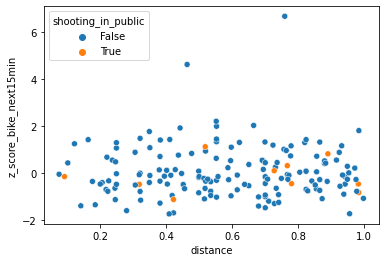

In [45]:
sns.scatterplot(data=shooting_df_2, x='distance', y='z_score_bike_next15min',hue='shooting_in_public')

## 4. Genre

We have decided to tell our story using the magazine style. This is because we want to have the users engaged in the story, and the ability to use visual in the magazine style is perfect for this. We have spent a lot of hours making beautiful heatmaps, bar plots, scatter plots, and more which we want to show to the world, but in order to tell a story we need some text to accompany these visuals, which is why we chose the magazine style.

**Visual narrative:**
- For the visual structuring we have a consistent visual platform, i.e. our website. Since the user will be scrolling through our website we will also have a progress bar. We have decided to go with this visul structure becasue the focus should be on the story and our visuals.
- We use a lot of feature distinction in our website. Most of our plots are about highlighting different features of our data. For example, we highlight how many of the shooting incidents were murders vs how many weren't. Another form where we use highlighting is by zooming, as we give the user the possibility of zooming in our heatmaps.
- Since our story is being told on a static webpage, we don't have any transitions.

**Narrative structure:**
- For the ordering we have used a linear style, since we want to tell a story where the topics build on top of each other. We first have an introduction about shooting in New York City, including talking about it's gun laws. We will then go on to analyse shooting incidents, before analysing the impact of shooting incidents on other aspects such as construction and school attendance. Finally we conclude everything. We want the user to follow this order which is why we have chosen a linear ordering of our story.
- Since we have gone with a magazine style, the interactivity for the user is limited to the visuals we have (i.e. we have no navigating between different pages). We have some heatmaps, where the user is able to move around the map and zoom in and out.
- For the messaging we have captions, annotations, intoductury text, a summary, and an accompanying article. Our visuals have captions and annotation such that they also make sense when seen without reading the article, and our article/story has an introduction and summary.

## 5. Visualizations

## 6. Discussion

## 7. Contributions